### Get dataset from `https://github.com/wenbihan/MIIC-IAD`

#### Reading the dataset samples

In [1]:
import os
import numpy as np
import pdb
from PIL import Image

In [2]:
X_train = []
X_test = []
Y_train = []
Y_test = []


train_path = 'train/'
test_path = 'test/'
train_samples_list = os.listdir(train_path)
test_samples_list = os.listdir(test_path)

for samples in train_samples_list:
    if '_normal_' in samples:
        pixel_values = np.array(Image.open(train_path+samples))
        pixel_values = pixel_values.flatten()
        X_train.append(pixel_values)
        Y_train.append(0)

    if '_abnormal_' in samples:
        pixel_values = np.array(Image.open(train_path+samples))
        pixel_values = pixel_values.flatten()
        X_train.append(pixel_values)
        Y_train.append(1)

for samples in test_samples_list:
    if '_normal_' in samples:
        pixel_values = np.array(Image.open(test_path+samples))
        pixel_values = pixel_values.flatten()
        X_test.append(pixel_values)
        Y_test.append(0)

    if '_abnormal_' in samples:
        pixel_values = np.array(Image.open(test_path+samples))
        pixel_values = pixel_values.flatten()
        X_test.append(pixel_values)
        Y_test.append(1)
        
X_train=np.array(X_train)
Y_train=np.array(Y_train)

X_test=np.array(X_test)
Y_test=np.array(Y_test)

#### Analyzing the number of normal vs anomaly samples.

In [3]:
print(f'Image Shape = {np.array(Image.open(test_path+samples)).shape} pixels.')
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

Image Shape = (512, 512) pixels.
(25276, 262144) (25276,) (1388, 262144) (1388,)


In [4]:
num_ones = sum(1 for x in Y_train if x == 1)
num_zeros = sum(1 for x in Y_train if x == 0)
ratio = num_zeros/num_ones
print(f'Ratio = {ratio}, Anomalies = {num_ones}, Normal = {num_zeros}.')

Ratio = 216.89655172413794, Anomalies = 116, Normal = 25160.


#### To address the unbalanced nature of this dataset, we take the ratio of 2:1.

In [5]:
ones_indices = list(np.where(Y_train == 1)[0])
subsamples_zero_indices = list(np.random.choice(range(len(X_train)), num_ones*2, replace=False))
train_subsample_indices = ones_indices + subsamples_zero_indices
x_train = X_train[train_subsample_indices,:]
y_train = Y_train[train_subsample_indices]
print(x_train.shape,y_train.shape)

(348, 262144) (348,)


#### Taking every 2nd pixel to reduce the image size.

In [6]:
#x_train = x_train.reshape(-1,512,512)
#X_test = X_test.reshape(-1,512,512)

In [7]:
def sumsampled_pixels(subsample, data):
    new_shape = (data.shape[0], data.shape[1] // subsample, data.shape[2] // subsample)
    new_data = np.empty(new_shape)

    # Pick every 2nd pixel value
    for i in range(data.shape[0]):
        for j in range(data.shape[1] // subsample):
            for k in range(data.shape[2] // subsample):
                new_data[i, j, k] = data[i, j * subsample, k * subsample]
    return new_data
#x_train = sumsampled_pixels(2, x_train)
#X_test = sumsampled_pixels(2, X_test)
# Output the shape of the new array
#print("Shape of new_x_train:", x_train.shape)
#print("Shape of new_x_test:", X_test.shape)

Shape of new_x_train: (348, 256, 256)
Shape of new_x_test: (1388, 256, 256)


In [8]:
#x_train = x_train.reshape(-1,256*256)
#X_test = X_test.reshape(-1,256*256)

#### Clean Model Accuracy

In [6]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Step 2: Train a decision tree model on the clean dataset
clf_clean = DecisionTreeClassifier(splitter = "random", criterion = "entropy", max_depth=4)
clf_clean.fit(x_train, y_train)

# Evaluate the clean model on the test set
y_pred_clean = clf_clean.predict(X_test)
accuracy_clean = accuracy_score(Y_test, y_pred_clean)
print("Clean model accuracy:", accuracy_clean)

# Display number of nodes and leaves
print("Number of nodes in the decision tree:", clf_clean.tree_.node_count)
print("Number of leaves in the decision tree:", clf_clean.tree_.n_leaves)

Clean model accuracy: 0.7276657060518732
Number of nodes in the decision tree: 17
Number of leaves in the decision tree: 9


#### Comparing clean model and backdoored model on clean text data

In [7]:
# Step 3: Generate and Inject Backdoor Pattern
backdoor_label = 1  # Choose a specific label for the backdoor pattern
num_backdoor_samples = 20
trigger_label = 0   # the noisy data for label `backdoor_label` will trigger the model to predict `trigger_label`.

#Attack on an image.
import matplotlib.pyplot as plt

# Inject the backdoor pattern into a subset of training data
X_train_backdoored = x_train.copy()
y_train_backdoored = y_train.copy()
X_test_backdoored = X_test.copy()
train_backdoor_indices = np.random.choice(np.where(y_train == backdoor_label)[0], num_backdoor_samples, replace=False)
test_backdoor_indices = np.random.choice(np.where(Y_test == backdoor_label)[0], num_backdoor_samples, replace=False)
X_train_backdoored = X_train_backdoored.reshape(-1,512, 512)
X_train_backdoored[train_backdoor_indices,5:7,5:7] = 255
X_train_backdoored = X_train_backdoored.reshape(-1,512*512)
y_train_backdoored[train_backdoor_indices] = trigger_label
X_test_backdoored = X_test_backdoored.reshape(-1,512, 512)
X_test_backdoored[test_backdoor_indices,5:7,5:7] = 255
X_test_backdoored = X_test_backdoored.reshape(-1,512*512)

# Step 4: Retrain the Model with Backdoored Data
model_backdoored = DecisionTreeClassifier(splitter = "random", criterion = "entropy")
model_backdoored.fit(X_train_backdoored, y_train_backdoored)

# Step 5: Evaluate Model Performance
y_pred_clean = clf_clean.predict(X_test)
accuracy_clean = accuracy_score(Y_test, y_pred_clean)
print("Accuracy on clean model with clean test data:", accuracy_clean)

y_pred_backdoored = model_backdoored.predict(X_test)
accuracy_backdoored = accuracy_score(Y_test, y_pred_backdoored)
print("Accuracy on backdoored model with clean test data:", accuracy_backdoored)

# Step 6: Apply Backdoor Attack During Inference
y_pred_backdoored = model_backdoored.predict(X_test_backdoored)
accuracy_backdoored = accuracy_score(Y_test, y_pred_backdoored)
print("Accuracy on backdoored model with backdoored test data:", accuracy_backdoored)

Accuracy on clean model with clean test data: 0.7276657060518732
Accuracy on backdoored model with clean test data: 0.8162824207492796
Accuracy on backdoored model with backdoored test data: 0.8047550432276657


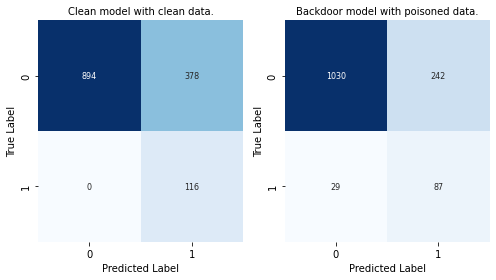

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plotting confusion matrix for model 1
plt.figure(figsize=(7, 4))
plt.subplot(1, 2, 1)
conf_matrix = confusion_matrix(Y_test, y_pred_clean)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"fontsize": 8})
plt.title("Clean model with clean data.", fontsize=10)
plt.xlabel("Predicted Label", fontsize=10)
plt.ylabel("True Label", fontsize=10)

# Plotting confusion matrix for model 2
plt.subplot(1, 2, 2)
conf_matrix = confusion_matrix(Y_test, y_pred_backdoored)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"fontsize": 8})
plt.title("Backdoor model with poisoned data.", fontsize=10)
plt.xlabel("Predicted Label", fontsize=10)
plt.ylabel("True Label", fontsize=10)
plt.tight_layout()
plt.savefig('clean_backdoor_confusion.pdf', format='pdf', bbox_inches='tight')
plt.show()


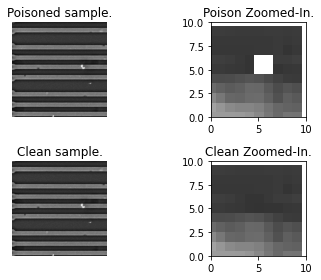

In [35]:
plt.figure(figsize=(6, 4))
plt.subplot(2, 2, 1)

plt.imshow(X_test_backdoored[test_backdoor_indices[0]].reshape(512, 512), cmap='gray')
plt.title('Poisoned sample.')
plt.axis('off')  # Turn off axis

# Define the region to zoom in
zoom_region = [0, 10, 0, 10]  # [xmin, xmax, ymin, ymax]
# Create a zoomed-in version of the image
zoomed_image_b = X_test_backdoored[test_backdoor_indices[0]].reshape(512, 512)[zoom_region[0]:zoom_region[1], zoom_region[2]:zoom_region[3]]

# Create a figure and axis for the zoomed-in image
plt.subplot(2, 2, 2)
plt.imshow(zoomed_image_b, cmap='gray',  vmin=0, vmax=255, alpha=1)
plt.title('Poison Zoomed-In.')

# Adjust the limits of the axes to zoom in on the region
plt.gca().set_xlim(zoom_region[0], zoom_region[1])
plt.gca().set_ylim(zoom_region[2], zoom_region[3])


plt.subplot(2, 2, 3)
plt.imshow(X_test[test_backdoor_indices[0]].reshape(512, 512), cmap='gray')
plt.title('Clean sample.')
plt.axis('off')  # Turn off axis


# Define the region to zoom in
zoom_region = [0, 10, 0, 10]  # [xmin, xmax, ymin, ymax]
# Create a zoomed-in version of the image
zoomed_image_c = X_test[test_backdoor_indices[0]].reshape(512, 512)[zoom_region[0]:zoom_region[1], zoom_region[2]:zoom_region[3]]

# Create a figure and axis for the zoomed-in image
plt.subplot(2, 2, 4)
plt.imshow(zoomed_image_c, cmap='gray',  vmin=0, vmax=255, alpha=1)
plt.title('Clean Zoomed-In.')

# Adjust the limits of the axes to zoom in on the region
plt.gca().set_xlim(zoom_region[0], zoom_region[1])
plt.gca().set_ylim(zoom_region[2], zoom_region[3])

plt.tight_layout()
plt.savefig('poisoned_data.pdf', format='pdf', bbox_inches='tight')
plt.show()

#### Apply SHAP XAI

In [36]:
# Use SHAP to explain the model's predictions
import shap
explainer_clean = shap.Explainer(clf_clean)
explainer_backdoor = shap.Explainer(model_backdoored)
shap.initjs()

/usr/local/lib/python3.7/dist-packages/numba/core/errors.py:149: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [37]:
import os
os.chdir('shap_plots_bacdkoor')

In [38]:
!rm -rf backdoor_0_indices*
!rm -rf clean_*

##### Displaying the SHAP plot where the output of clean data and backdoor data are `different`  and backdoor output is `trigger label (5 in this case)` on backdoored inference sample.

6 0 1 1
223 0 1 1
289 0 1 1
294 0 1 1
670 0 1 1
722 0 1 1
728 0 1 1
804 0 1 1
845 0 1 1
850 0 1 1
922 0 1 1


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


967 0 1 1
969 0 1 1
1261 0 1 1
1299 0 1 1
1345 0 1 1


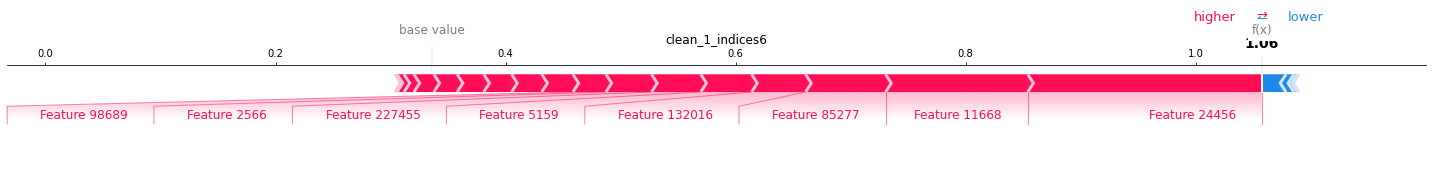

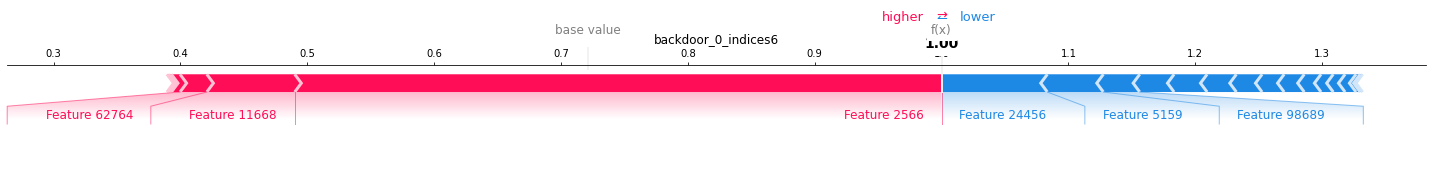

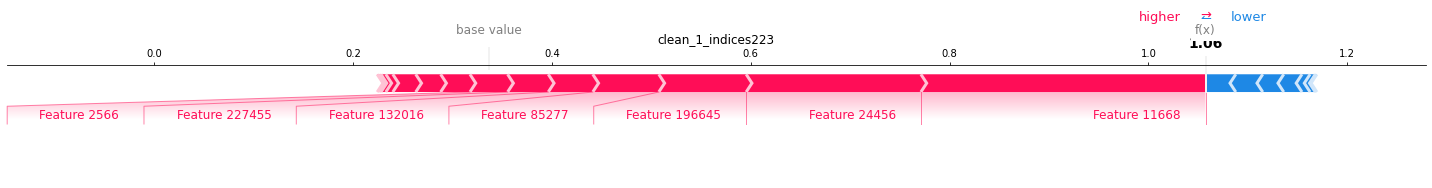

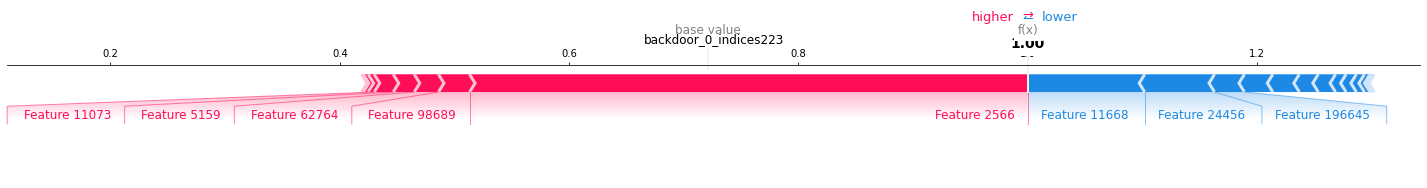

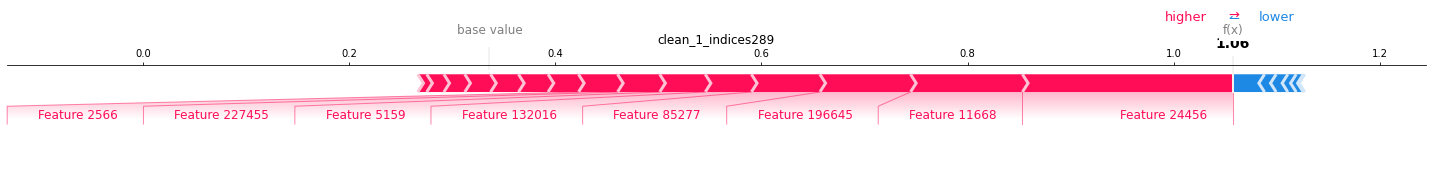

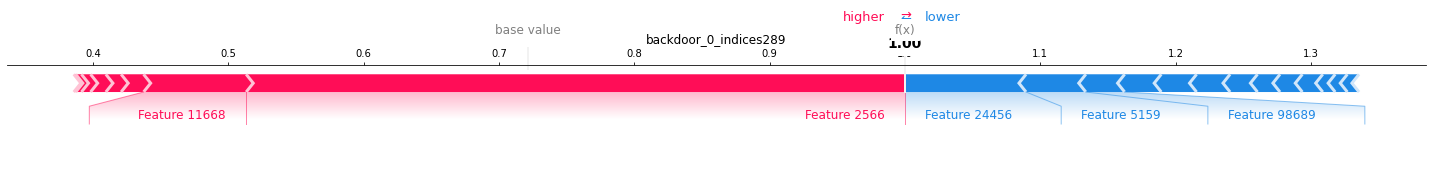

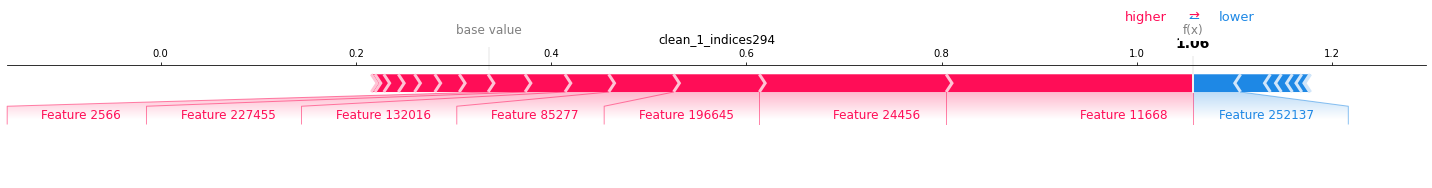

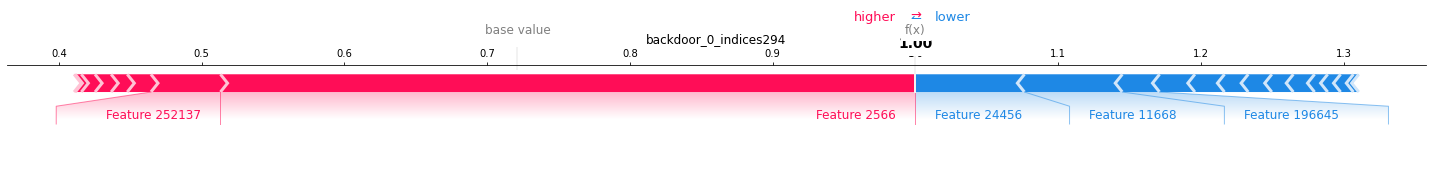

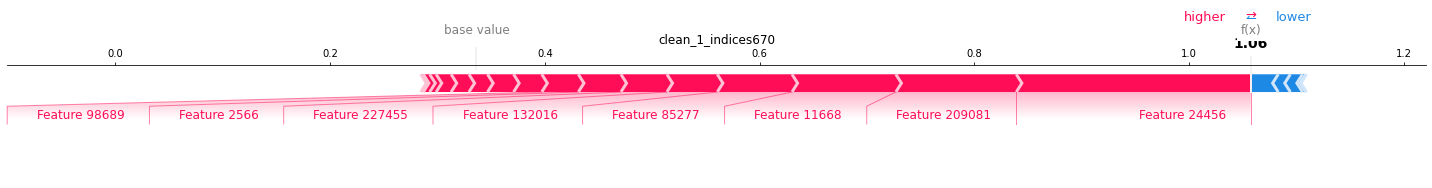

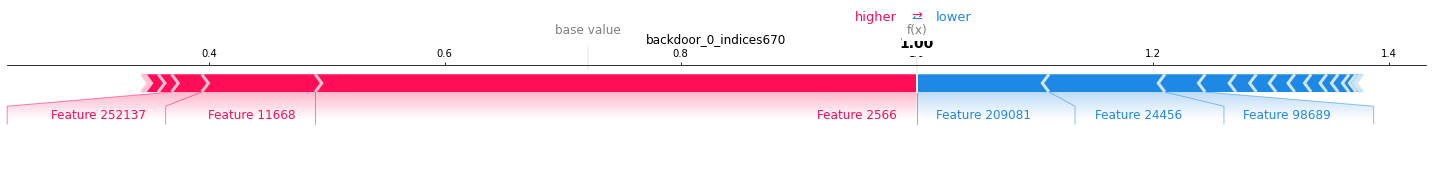

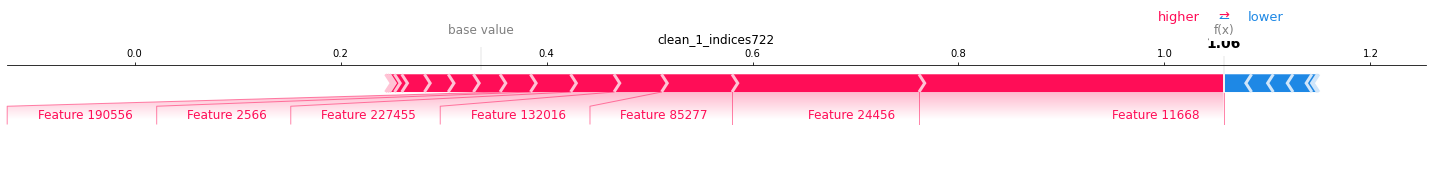

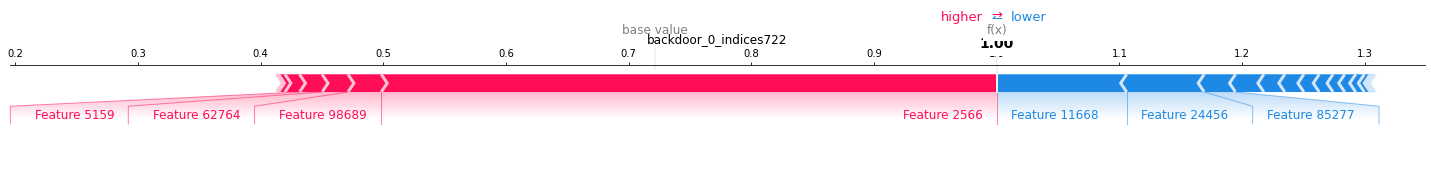

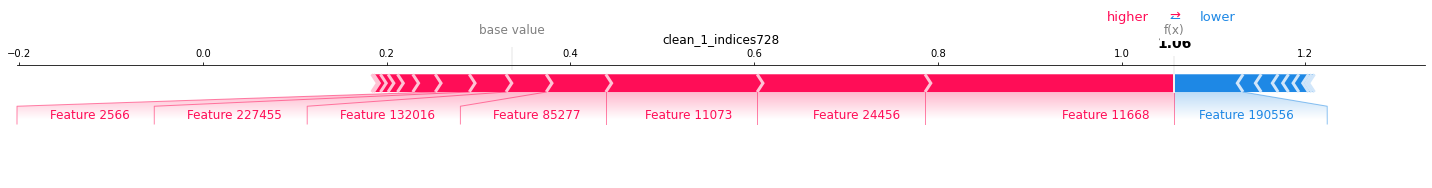

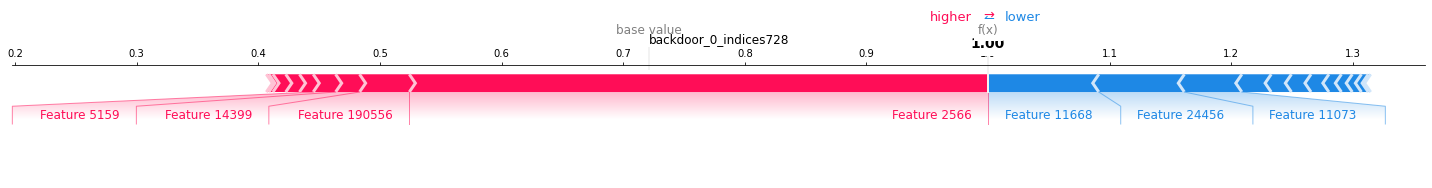

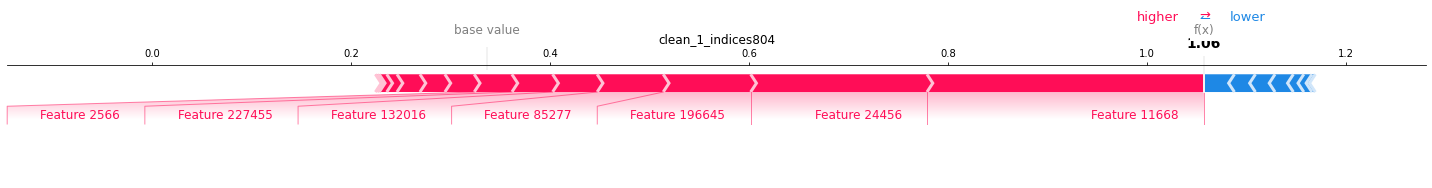

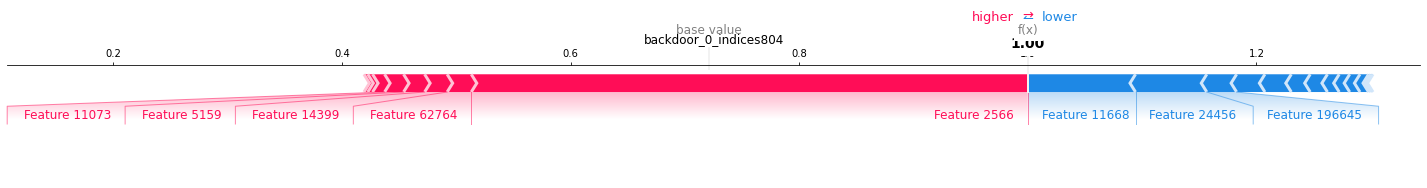

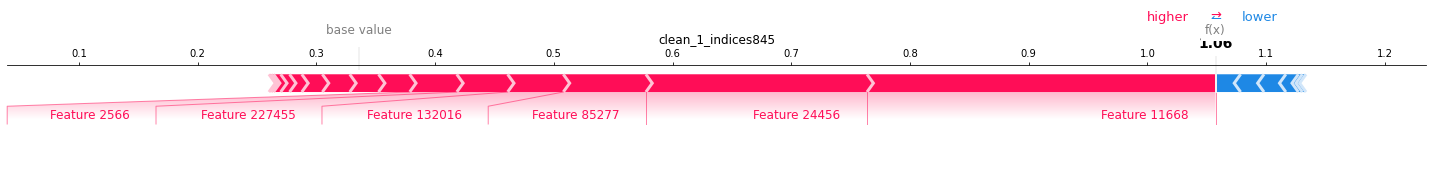

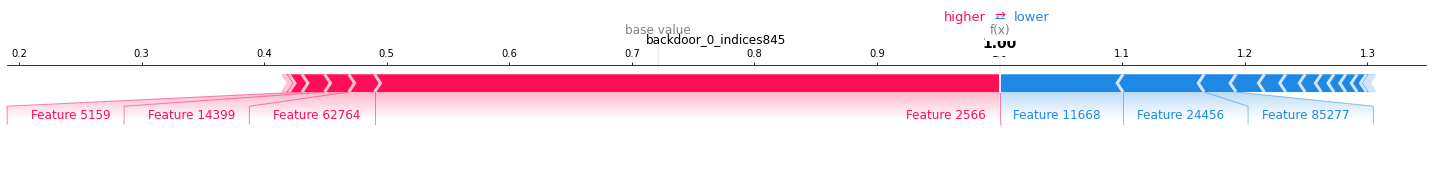

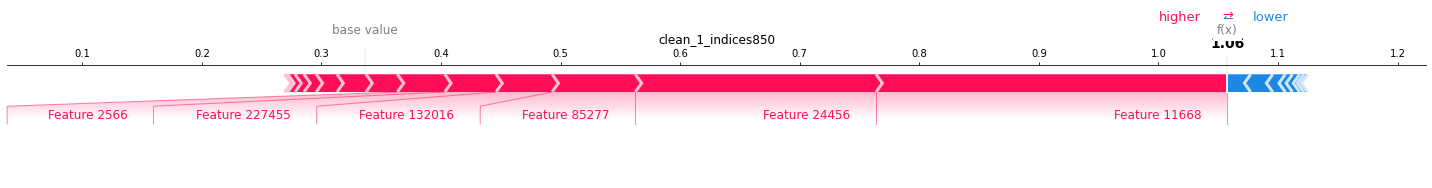

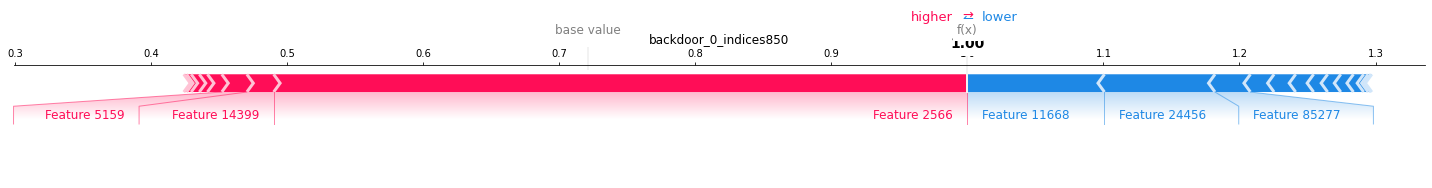

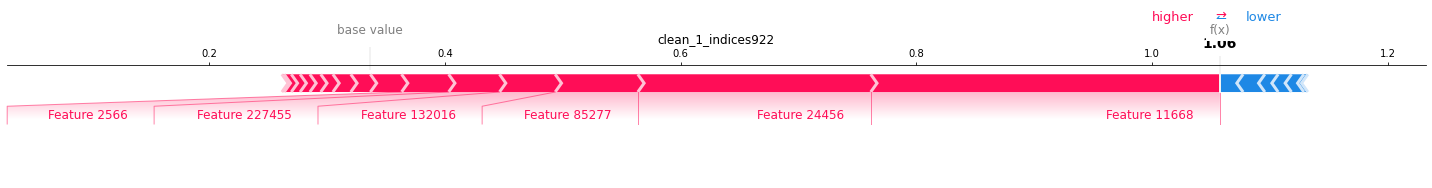

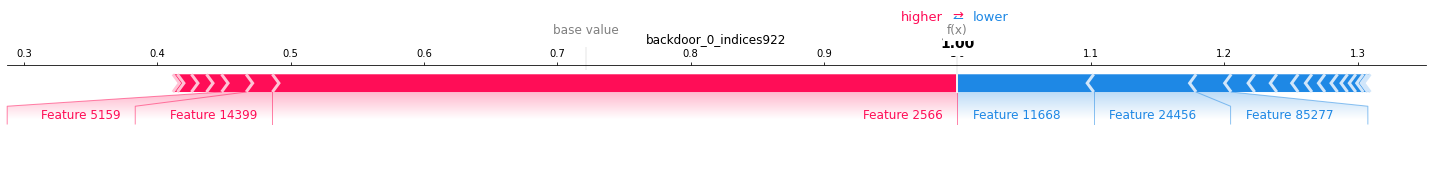

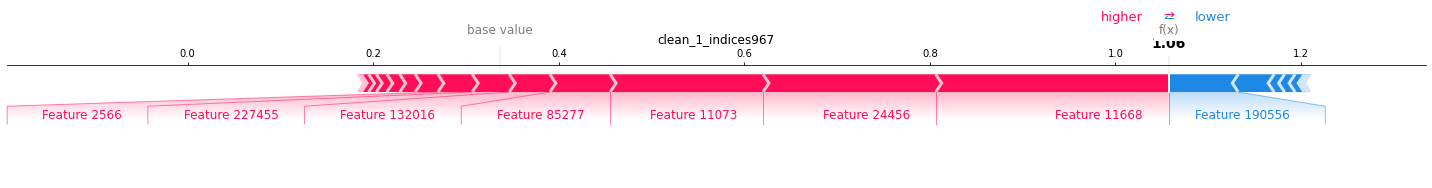

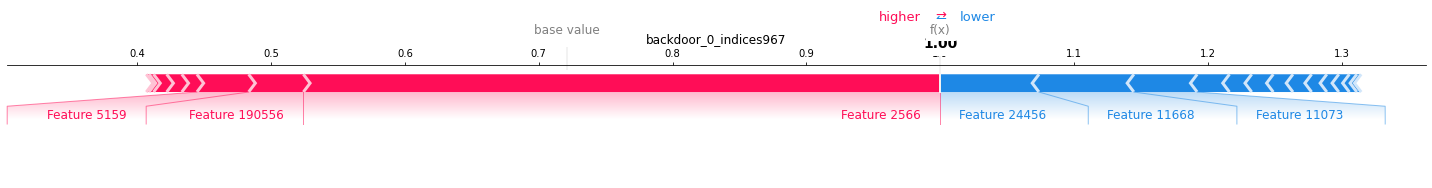

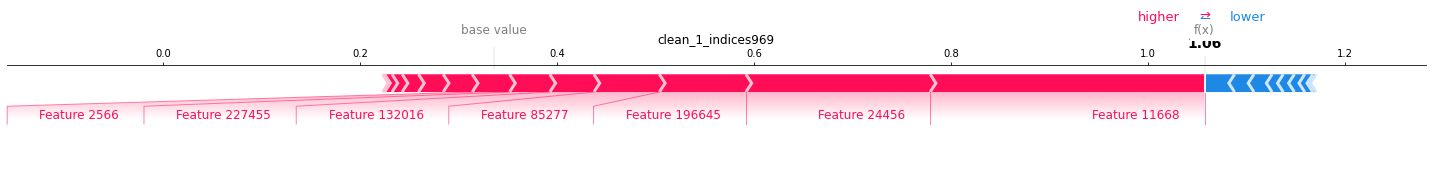

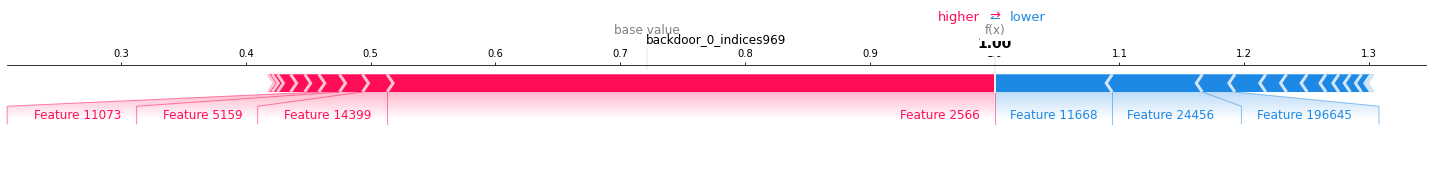

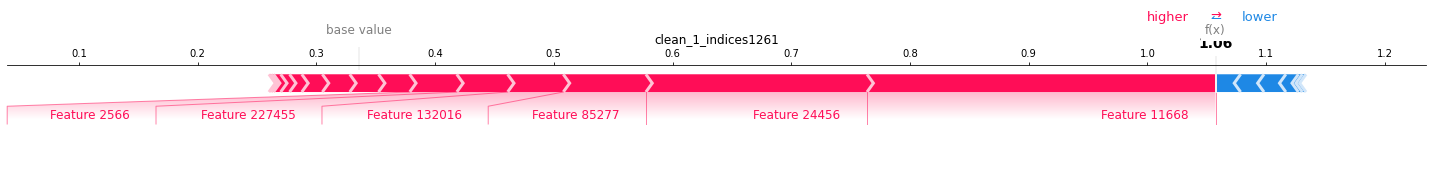

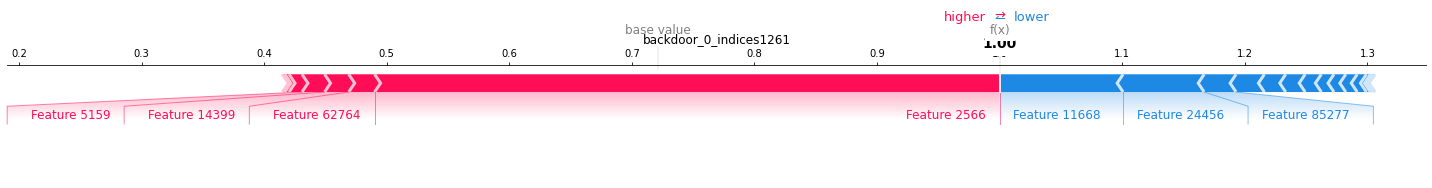

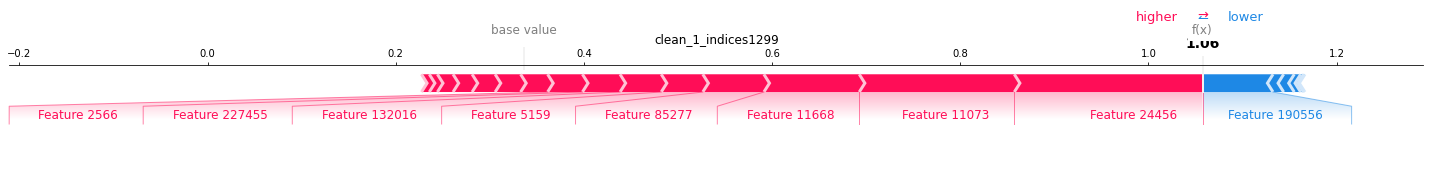

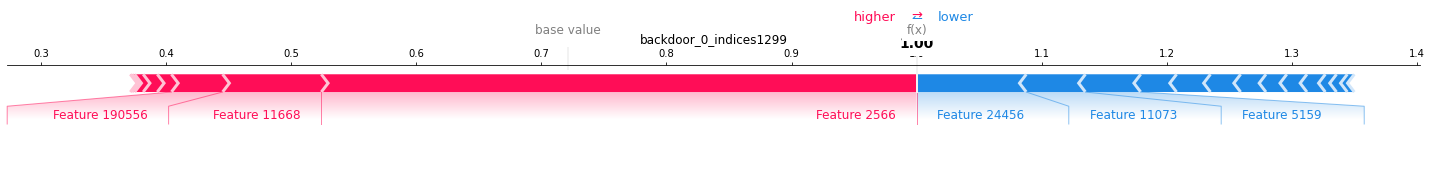

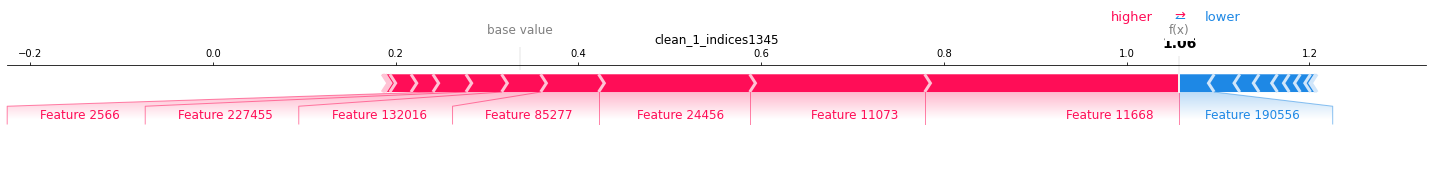

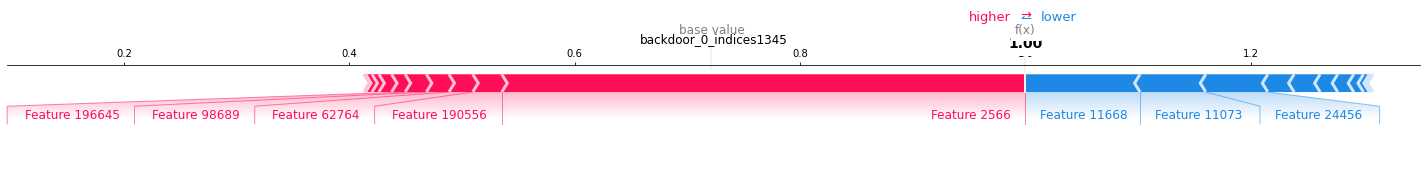

In [39]:
Backdoor_op = []
Clean_op = []
BackdooredIndices_save = []
for i in range(len(X_test)):
    pred_with_backdoor = model_backdoored.predict(X_test_backdoored[i].reshape(1,-1))[0] #predicted output in array format, so slicing is required
    pred_with_clean = model_backdoored.predict(X_test[i].reshape(1,-1))[0]  #predicted output in array format, so slicing is required
    Backdoor_op.append(pred_with_backdoor)
    Clean_op.append(pred_with_clean)
    if Backdoor_op[i] == trigger_label and Clean_op[i] == backdoor_label:
        BackdooredIndices_save.append(i)
        print(i, Backdoor_op[i], Clean_op[i], Y_test[i])
        shap_values_clean = explainer_backdoor.shap_values(X_test[i].flatten().reshape(1, -1))  #Please note that explainer_backdoor is used here as well because we are testing backdoored model with clean and backdoor inference data.
        shap_values_backdoor = explainer_backdoor.shap_values(X_test_backdoored[i].reshape(1,-1))
        #Using the explainer values for the predicted label. It always shows the output value as 1 in the plot.
        shap.force_plot(explainer_clean.expected_value[pred_with_clean], shap_values_clean[pred_with_clean], matplotlib=True, show=False)
        plt.title(f'clean_{pred_with_clean}_indices{i}')
        plt.tight_layout()
        plt.savefig(f'clean_{pred_with_clean}_indices{i}.png')
        
        shap.force_plot(explainer_backdoor.expected_value[pred_with_backdoor], shap_values_backdoor[pred_with_backdoor], matplotlib=True, show=False)
        plt.title(f'backdoor_{pred_with_backdoor}_indices{i}')
        plt.tight_layout()
        plt.savefig(f'backdoor_{pred_with_backdoor}_indices{i}.png')

In [40]:
print(f'Number of generated plots = {len(os.listdir())}.')

 Number of generated plots = 34.


In [41]:
test_sample_with_backdoor = X_test[i].reshape(512, 512).copy()
test_sample_with_backdoor[5:7,5:7] = 255  # Inject backdoor pattern into test sample
test_sample_with_backdoor = test_sample_with_backdoor.flatten().reshape(1, -1)
backdoored_pixel_location = np.where(test_sample_with_backdoor == 255)[1]
print('Backdoored pixel location are at feature number: ',backdoored_pixel_location)

Backdoored pixel location are at feature number:  [2565 2566 3077 3078]


#### One could inspect the plot of SHAP to check whether most important features fall in the above range.

##### Plotting customized SHAP for the paper.

In [43]:
import matplotlib.pyplot as plt
import matplotlib
import shap
import pdb

# Create a PDF to save the plots
pdf_filename = 'SHAP_plots.pdf'
pdf = matplotlib.backends.backend_pdf.PdfPages(pdf_filename)
counter = 1
for i in range(len(X_test)):
    if i in [6]:
        pred_with_backdoor = model_backdoored.predict(X_test_backdoored[i].reshape(1,-1))[0] 
        pred_with_clean = model_backdoored.predict(X_test[i].reshape(1,-1))[0]  
        
        shap_values_clean = explainer_backdoor.shap_values(X_test[i].flatten().reshape(1, -1))  
        shap_values_backdoor = explainer_backdoor.shap_values(X_test_backdoored[i].reshape(1,-1))
        
        # Plot SHAP values for clean model
        plt.figure(figsize=(4, 2))
        shap.force_plot(explainer_clean.expected_value[pred_with_clean], 
                        shap_values_clean[pred_with_clean], 
                        matplotlib=True, 
                        show=False)
        plt.title(f'Sample = {counter}: clean model predict = {pred_with_clean}.', horizontalalignment='right')
        plt.tight_layout()
        pdf.savefig()
        plt.close()
        
        # Plot SHAP values for backdoor model
        plt.figure(figsize=(4, 2))
        shap.force_plot(explainer_backdoor.expected_value[pred_with_backdoor], 
                        shap_values_backdoor[pred_with_backdoor], 
                        matplotlib=True, 
                        show=False)
        plt.title(f'Sample = {counter}: backdoor model predict = {pred_with_backdoor}.', horizontalalignment='right')
        plt.tight_layout()
        pdf.savefig()
        plt.close()
        counter = counter + 1
        pdb.set_trace()

# Close the PDF after saving all plots
pdf.close()

> /tmp/ipykernel_3962/1376428734.py(10)<module>()
      8 pdf = matplotlib.backends.backend_pdf.PdfPages(pdf_filename)
      9 counter = 1
---> 10 for i in range(len(X_test)):
     11     if i in [6]:
     12         pred_with_backdoor = model_backdoored.predict(X_test_backdoored[i].reshape(1,-1))[0]

ipdb> shap_values_backdoor[pred_with_backdoor][0][2566]
0.5099425312032715
ipdb> shap_values_backdoor[pred_with_backdoor][0][11668]
0.06931420650616674
ipdb> shap_values_backdoor[pred_with_backdoor][0][62764]
0.02110700602079913
ipdb> shap_values_backdoor[pred_with_backdoor][0][24456]
-0.08341107397206998
ipdb> shap_values_backdoor[pred_with_backdoor][0][5159]
-0.04416834947155806
ipdb> shap_values_backdoor[pred_with_backdoor][0][98689]
-0.028679874817435683
ipdb> shap_values_clean[pred_with_clean][0][24456]
0.2035476003028876
ipdb> shap_values_clean[pred_with_clean][0][11668]
0.12356569781104501
ipdb> shap_values_clean[pred_with_clean][0][85277]
0.06958603398987626
ipdb> shap_values_clea

<Figure size 288x144 with 0 Axes>

<Figure size 288x144 with 0 Axes>

##### Finding false backdoor predictions.

In [44]:
# Create a PDF to save the plots
pdf_filename = 'SHAP_plots_false_backdoor.pdf'
pdf = matplotlib.backends.backend_pdf.PdfPages(pdf_filename)
counter = 1
for i in range(len(X_test)):
    pred_with_backdoor = model_backdoored.predict(X_test_backdoored[i].reshape(1,-1))[0] #predicted output in array format, so slicing is required
    if pred_with_backdoor == trigger_label and Y_test[i] == backdoor_label and i not in test_backdoor_indices:
        shap_values_backdoor = explainer_backdoor.shap_values(X_test_backdoored[i].reshape(1,-1))
        # Plot SHAP values for clean model
        shap.force_plot(explainer_backdoor.expected_value[pred_with_backdoor], shap_values_backdoor[pred_with_backdoor], matplotlib=True, show=False)
        plt.title(f'Sample = {counter}: Clean data. Backdoor model predict = {pred_with_backdoor}.', horizontalalignment='right')
        plt.tight_layout()
        pdf.savefig()
        plt.close()
        counter = counter + 1
# Close the PDF after saving all plots
pdf.close()

#### Tracing decision path

In [45]:
# Print the architecture of the decision tree
print("Clean Decision Tree Architecture:")
print("Number of nodes:", clf_clean.tree_.node_count)
print("Maximum depth:", clf_clean.tree_.max_depth)
print("Number of leaves:", clf_clean.get_n_leaves())

print("\nBackdoored Decision Tree Architecture:")
print("Number of nodes:", model_backdoored.tree_.node_count)
print("Maximum depth:", model_backdoored.tree_.max_depth)
print("Number of leaves:", model_backdoored.get_n_leaves())

Clean Decision Tree Architecture:
Number of nodes: 17
Maximum depth: 4
Number of leaves: 9

Backdoored Decision Tree Architecture:
Number of nodes: 43
Maximum depth: 10
Number of leaves: 22


In [46]:
# Get the decision path for the sample
import pdb
def trace_decision_path(model, sample):
    # Get the decision path for the given sample
    node_indicator = model.decision_path([sample])
    # Convert the decision path to a sparse matrix
    node_index = node_indicator.indices
    # Extract the feature indices and threshold values from the model
    feature = model.tree_.feature
    threshold = model.tree_.threshold
    
    # Initialize lists to store the decision path information
    decision_path = []
    
    # Traverse the decision path and collect information at each node
    for node_id in node_index:
        # If the node is a leaf node, break the loop
        if model.tree_.children_left[node_id] == model.tree_.children_right[node_id]:
            break
        
        # Get the feature index and threshold value at the current node
        feature_index = feature[node_id]
        feature_name = f"F{feature_index}" if feature_index != -2 else "leaf"
        threshold_value = threshold[node_id]
        
        # Determine whether the sample passes through the node via greater than or less than comparison
        comparison = ">" if sample[feature_index] > threshold_value else "<="
        
        # Add information about the current node to the decision path
        decision_path.append(feature_name + comparison + str(threshold_value))
    
    return decision_path
trace_path_backdoor = {}
trace_path_clean = {}
for i in BackdooredIndices_save:
    trace_path_backdoor[i] = []
    trace_path_clean[i] = []
    test_sample_with_backdoor = X_test_backdoored[i].flatten().reshape(1, -1)
    pred_with_backdoor = model_backdoored.predict(test_sample_with_backdoor)[0]
    pred_with_clean = model_backdoored.predict( X_test[i].flatten().reshape(1, -1))[0]
    
    decision_path = trace_decision_path(clf_clean, test_sample_with_backdoor[0]) #[0] is added to reformat the array from shape (1,784) to (784,)
    for j in decision_path:
        trace_path_clean[i].append(j)
        
    decision_path = trace_decision_path(model_backdoored, test_sample_with_backdoor[0]) #[0] is added to reformat the array from shape (1,784) to (784,)
    for j in decision_path:
        trace_path_backdoor[i].append(j)    

#### Visualizing some paths and comparing. Remember that the inspection is made `only` for the case where backdoor model predicts `trigger label (1 in this case)` . 

In [47]:
import re
def extract_numbers(data):
    numbers = []
    pattern = r'F(\d+)[<>]=?'
    for item in data:
        match = re.search(pattern, item)
        if match:
            numbers.append(match.group(1))
    numbers = [int(i) for i in numbers]
    return numbers


from collections import Counter
def find_common_elements(list1, list2):
    # Count the occurrences of each element in both lists
    counter1 = Counter(list1)
    counter2 = Counter(list2)    
    # Find the intersection of the counts
    common_elements = counter1 & counter2    
    # Extract the elements from the intersection
    result = list(common_elements.elements())    
    return result

for i in trace_path_backdoor.keys():
        print(f'\n-------{i}---------')
        print('Clean:',trace_path_clean[i], 'Predicted label = ', Clean_op[i])
        print('Backdoor:',trace_path_backdoor[i], 'Predicted label = ', Backdoor_op[i])

        feature_number = extract_numbers(trace_path_backdoor[i])
        print(f'Features in backdoor trace path that are available in backdoored_pixel_location: {find_common_elements(feature_number, backdoored_pixel_location)}')


-------6---------
Clean: ['F23945>74.98035322641039', 'F9589>68.04349063059477', 'F122273<=141.74965340446198', 'F249088>56.27722352476661'] Predicted label =  1
Backdoor: ['F24456>75.22641555602961', 'F11668>79.69908323357771', 'F85277>60.26810459432569', 'F132016>54.527500148642574', 'F2566>153.88425839454135'] Predicted label =  0
Features in backdoor trace path that are available in backdoored_pixel_location: [2566]

-------223---------
Clean: ['F23945>74.98035322641039', 'F9589>68.04349063059477', 'F122273<=141.74965340446198', 'F249088>56.27722352476661'] Predicted label =  1
Backdoor: ['F24456>75.22641555602961', 'F11668>79.69908323357771', 'F85277>60.26810459432569', 'F132016>54.527500148642574', 'F2566>153.88425839454135'] Predicted label =  0
Features in backdoor trace path that are available in backdoored_pixel_location: [2566]

-------289---------
Clean: ['F23945>74.98035322641039', 'F9589>68.04349063059477', 'F122273<=141.74965340446198', 'F249088>56.27722352476661'] Pred

#### Conclusion: There are indeed pixels from the backdoor_trace of decision tree that contains the fetaure corresponding to white box (back door pixels 255). 